# Ethereum Futures vs. ETH & Lido stETH


In [1140]:
#TODO: .pct_change()  vs.   .pct_change().dropna().corr()??

In [1141]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
PRICE_CME = 'Price_cme'
PRICE_ETH = 'Price_eth'
PRICE_STETH = 'Price_steth'
PRICE_CME_DELTA = 'Price_cme_delta'
PRICE_CME_PCT = 'Price_cme_return'
PRICE_ETH_DELTA = 'Price_eth_delta'
PRICE_ETH_PCT = 'Price_eth_return'
PRICE_STETH_DELTA = 'Price_steth_delta'
PRICE_STETH_PCT = 'Price_steth_return'

### Functions

In [1142]:
def show_price(df):
    """show price over time"""
    plt.figure(figsize=(15, 8))
    plt.plot(df['Entry Date UTC'], df[PRICE_CME], label='ETH Futures Price', color='#1f77b4', linewidth=2)
    plt.plot(df['Entry Date UTC'], df[PRICE_STETH], label='stETH Price', color='#ff7f0e', linewidth=1, alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('ETH Price ($)')
    plt.title('stETH vs Futures ETH Prices')
    plt.legend()
    plt.show()


In [1143]:
def show_scatters(df_cme_eth, df2_cme_steth, tf):
    """show scatter plot with regression line over price deltas"""
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.regplot(x=PRICE_CME_DELTA, y=PRICE_ETH_DELTA, data=df_cme_eth, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
    sns.scatterplot(x=PRICE_CME_DELTA, y=PRICE_ETH_DELTA, data=df_cme_eth)
    plt.title(f'ETH Futures vs. ETH')
    plt.xlabel('ETH Futures')
    plt.ylabel('ETH')

    plt.subplot(1, 2, 2)
    sns.regplot(x=PRICE_CME_DELTA, y=PRICE_STETH_DELTA, data=df2_cme_steth, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
    sns.scatterplot(x=PRICE_CME_DELTA, y=PRICE_STETH_DELTA, data=df2_cme_steth)
    plt.title(f'ETH Futures vs. stETH')
    plt.xlabel('ETH Futures')
    plt.ylabel('stETH')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # space for global title
    plt.suptitle(f'Scatter Plot of Correlation (deltas) on {tf}', fontsize=16, fontweight='bold')

    plt.show()

In [1144]:
def show_correlations(df_corr_eth, df_corr_steth, tf, corr_type):
    """Show static correlations"""

    print(f'{tf} correlation on {corr_type}: \n')
    print(f'\t{f"{df_corr_eth * 100:.2f}%"} : eth futures vs. eth\n')
    print(f'\t{f"{df_corr_steth * 100:.2f}%"} : eth futures vs. steth')

In [1145]:
def show_rolling_correlations(df_cme_eth, df2_cme_steth):
    """show rolling correlations on a 24h window"""

    plt.figure(figsize=(12, 6))
    plt.plot(df_cme_eth['Entry Date UTC'], df_cme_eth['rolling_corr'], label='ETH Futures vs. ETH', color='#1f77b4', linewidth=2)
    plt.plot(df2_cme_steth['Entry Date UTC'], df2_cme_steth['rolling_corr'], label='ETH Futures vs. stETH', color='#ff7f0e', linewidth=1, alpha=0.6)
    plt.title('Rolling Correlation Over Time (hourly intervals)', fontsize=16, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [1146]:
def remove_na(df1, df2):
    """remove pct values with `na` after applying correlation (normally the 1st record)"""
    
    df1 = df1.dropna(subset=[PRICE_CME_PCT, PRICE_ETH_PCT])
    df2 = df2.dropna(subset=[PRICE_CME_PCT, PRICE_STETH_PCT])
    return df1, df2

In [1147]:
def calc_deltas(df, price_cols):
    """calculate value difference and percentage difference of ETH Futures vs. ETH & stETH"""
    
    for col in price_cols:
        df[f'{col}_delta'] = df[col].diff()
        df[f'{col}_return'] = df[col].pct_change()

In [1148]:
def filter_period(df, start_date, end_date):
    """filter dataframes by a new period"""
    
    df_filtered = df.set_index('Entry Date UTC')[start_date:end_date]
    df_filtered.reset_index(inplace=True)
    return df_filtered

### Data Loading

In [1149]:
col_names = ['Entry Date UTC', 'Price']

# Load CME ETH data [from CME Group] on a minute basis
df_cme_1m = pd.read_csv('../data/cme/cme_1m_cme.csv', usecols=col_names)
df_cme_1m['Entry Date UTC'] = pd.to_datetime(
        df_cme_1m['Entry Date UTC'],
        format='%Y%m%dT%H:%M:%S',
        utc=True
    )
df_cme_1m.set_index('Entry Date UTC', inplace=True)

# Filter CME ETH data from 1m to 5m: getting the minute before every modulo 5 as the close price for
# eth futures vs. trading view every 5 min at open price for eth
# Then, assigning the price as modulo 5 in eth futures to be able to match with trading view's eth on dates
df_cme_5m = df_cme_1m[df_cme_1m.index.minute % 5 == 4]
df_cme_5m.index = df_cme_5m.index + pd.DateOffset(minutes=1)
df_cme_5m = df_cme_5m.reset_index()

# Filter CME ETH data from 1m to 1h
df_cme_1h = df_cme_1m[df_cme_1m.index.minute == 0].reset_index()

# Load ETH data [from Trading View]
df_eth_1h = pd.read_csv('../data/eth/eth_1h_tv.csv', usecols=col_names)
df_eth_1h['Entry Date UTC'] = pd.to_datetime(df_eth_1h['Entry Date UTC'], utc=True)

# Load stETH data [from Trading View]
df_steth_1h = pd.read_csv('../data/steth/steth_1h_tv.csv', usecols=col_names)
df_steth_1h['Entry Date UTC'] = pd.to_datetime(df_steth_1h['Entry Date UTC'], utc=True)

# TODO: load Dune data to show lower accuracy


### Data Processing

In [1150]:
# Merge dataframes
df_cme_eth = pd.merge(df_cme_1h, df_eth_1h, on='Entry Date UTC', suffixes=('_cme', '_eth'))
df_cme_steth = pd.merge(df_cme_1h, df_steth_1h, on='Entry Date UTC', suffixes=('_cme', '_steth'))

# Calc deltas
calc_deltas(df_cme_eth, [PRICE_CME, PRICE_ETH])
calc_deltas(df_cme_steth, [PRICE_CME, PRICE_STETH])

# Remove outliers
df_cme_eth, df_cme_steth = remove_na(df_cme_eth, df_cme_steth)

# Choose period range
df_cme_eth = filter_period(df_cme_eth, '2022-01-01', '2024-04-30')
df_cme_steth = filter_period(df_cme_steth, '2022-01-01', '2024-04-30')

### Correlation Analysis

In [1151]:
# Correlation on returns
corr_cme_eth_return = df_cme_eth[PRICE_CME_PCT].corr(df_cme_eth[PRICE_ETH_PCT])
corr_cme_steth_return = df_cme_steth[PRICE_CME_PCT].corr(df_cme_steth[PRICE_STETH_PCT])

# Correlation on prices
corr_cme_eth_price = df_cme_eth[PRICE_CME].corr(df_cme_eth[PRICE_ETH])
corr_cme_steth_price = df_cme_steth[PRICE_CME].corr(df_cme_steth[PRICE_STETH])

# Rolling Correlationsxw
window_size = 24  # 24 data points for 24 hours
df_cme_eth['rolling_corr'] = df_cme_eth[PRICE_CME_PCT].rolling(window=window_size).corr(df_cme_eth[PRICE_ETH_PCT])
df_cme_steth['rolling_corr'] = df_cme_steth[PRICE_CME_PCT].rolling(window=window_size).corr(df_cme_steth[PRICE_STETH_PCT])

### Outcomes

#### **Scenario 1**: Correlations on 1h timeframe [01.01.2023 to 30.04.2024]

In [1152]:
show_correlations(corr_cme_eth_price, corr_cme_steth_price, '1h', 'prices')
print(f'\n')
show_correlations(corr_cme_eth_return, corr_cme_steth_return, '1h', 'returns')

1h correlation on prices: 

	99.99% : eth futures vs. eth

	99.97% : eth futures vs. steth


1h correlation on returns: 

	98.09% : eth futures vs. eth

	71.20% : eth futures vs. steth


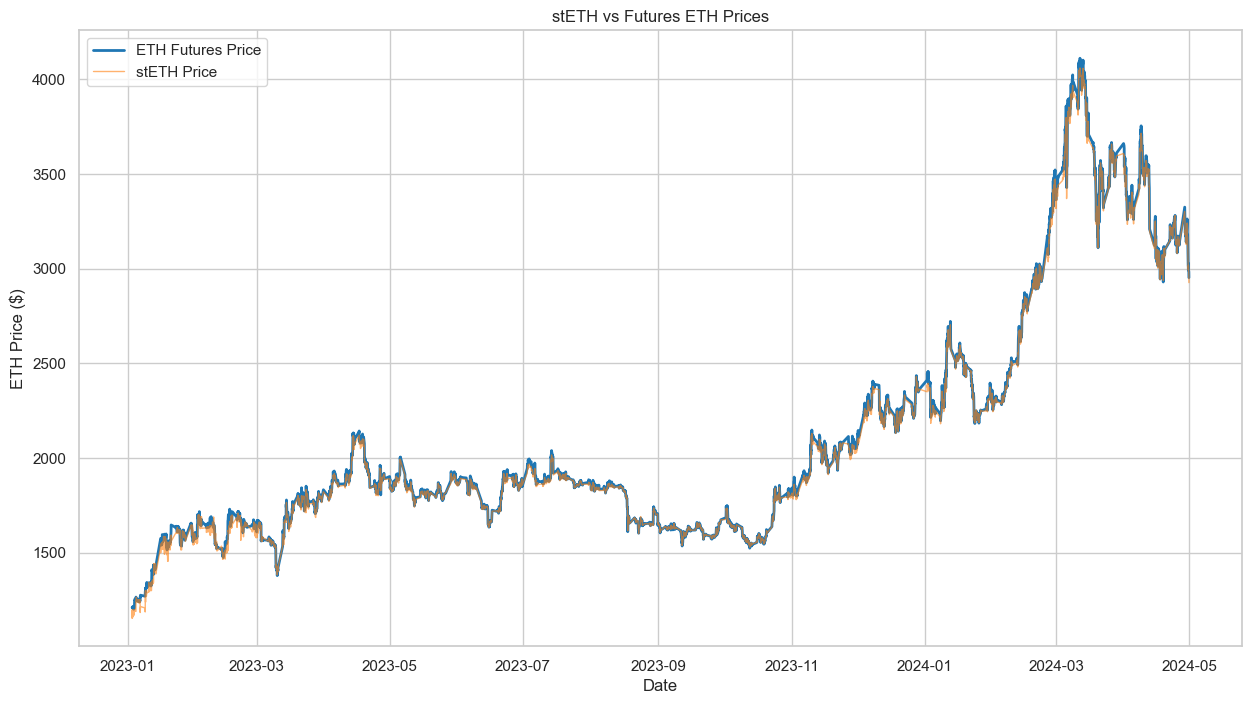

In [1153]:
show_price(df_cme_steth)

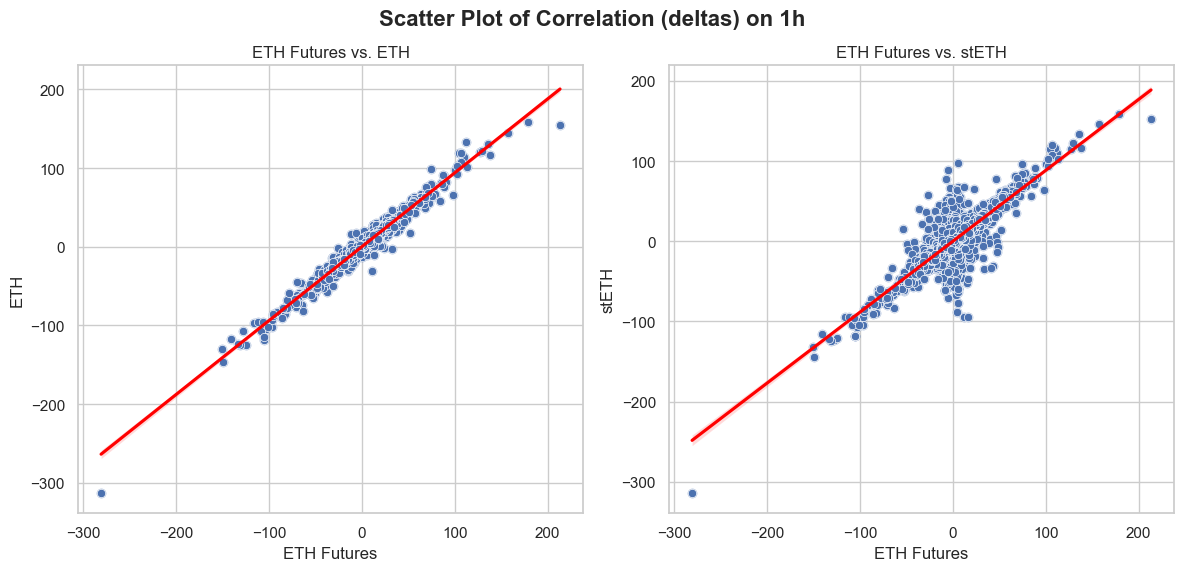

In [1154]:
show_scatters(df_cme_eth, df_cme_steth, '1h')

💡 conclusion tbd

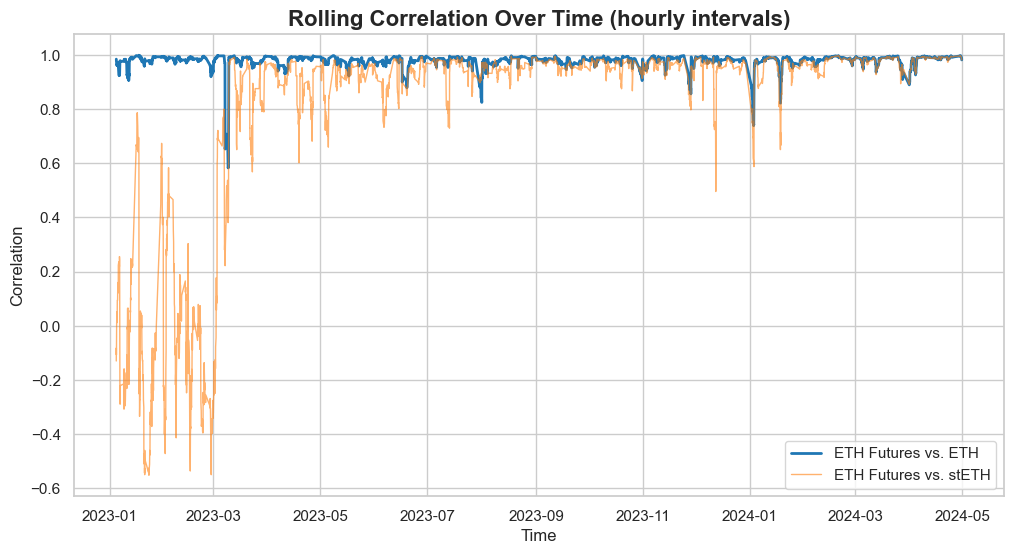

In [1155]:
show_rolling_correlations(df_cme_eth, df_cme_steth)

💡 conclusion tbd

In [1156]:
#TODO: outliers hunging

#### **Scenario 2**: Correlations on 1h timeframe [30.04.2023 to 30.04.2024]

In [1157]:
# Apply time filters
df_cme_eth_filtered = filter_period(df_cme_eth, '2023-04-30', '2024-04-30')
df_cme_steth_filtered = filter_period(df_cme_steth, '2023-04-30', '2024-04-30')

# Correlation on returns
corr_cme_eth_filtered_return = df_cme_eth_filtered[PRICE_CME_PCT].corr(df_cme_eth_filtered[PRICE_ETH_PCT])
corr_cme_steth_filtered_return = df_cme_steth_filtered[PRICE_CME_PCT].corr(df_cme_steth_filtered[PRICE_STETH_PCT])

# Correlation on prices
corr_cme_eth_filtered_price = df_cme_eth_filtered[PRICE_CME].corr(df_cme_eth_filtered[PRICE_ETH])
corr_cme_steth_filtered_price = df_cme_steth_filtered[PRICE_CME].corr(df_cme_steth_filtered[PRICE_STETH])

In [1158]:
show_correlations(corr_cme_eth_filtered_price, corr_cme_steth_filtered_price, '1h', 'prices')
print(f'\n')
show_correlations(corr_cme_eth_filtered_return, corr_cme_steth_filtered_return, '1h', 'returns')

1h correlation on prices: 

	99.99% : eth futures vs. eth

	99.99% : eth futures vs. steth


1h correlation on returns: 

	98.13% : eth futures vs. eth

	96.35% : eth futures vs. steth


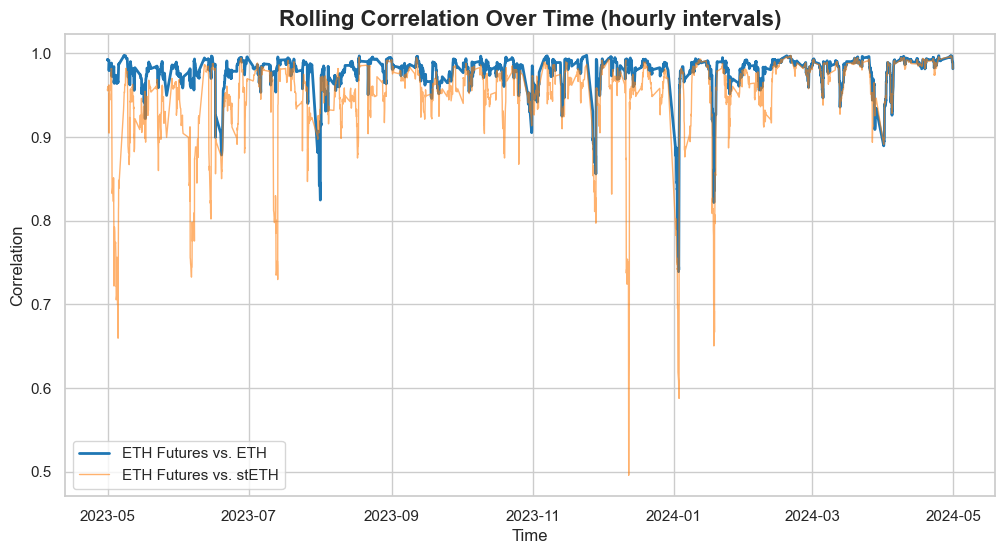

In [1159]:
df_cme_eth_filtered.reset_index(inplace=True)
df_cme_steth_filtered.reset_index(inplace=True)
show_rolling_correlations(df_cme_eth_filtered, df_cme_steth_filtered)

#### **Scenario 3**: Correlation on 5m timeframe [12.05.2024 - 12.06.2024]

In [1160]:
# Load ETH data [from Trading View] (may'24 to jun'24)
df_eth_5m = pd.read_csv('../data/eth/eth_5m_tv.csv', usecols=col_names)
df_eth_5m['Entry Date UTC'] = pd.to_datetime(df_eth_5m['Entry Date UTC'], utc=True)

# Load stETH data [from Trading View] (may'24 to jun'24)
df_steth_5m = pd.read_csv('../data/steth/steth_5m_tv.csv', usecols=col_names)
df_steth_5m['Entry Date UTC'] = pd.to_datetime(df_steth_5m['Entry Date UTC'], utc=True)

In [1161]:
# Merge datasets
df_cme_eth_5m = pd.merge(df_cme_5m, df_eth_5m, on='Entry Date UTC', suffixes=('_cme', '_eth'))
df_cme_steth_5m = pd.merge(df_cme_5m, df_steth_5m, on='Entry Date UTC', suffixes=('_cme', '_steth'))

calc_deltas(df_cme_eth_5m, ['Price_cme', 'Price_eth'])
calc_deltas(df_cme_steth_5m, ['Price_cme', 'Price_steth'])

# Remove outliers
df_cme_eth_5m, df_cme_steth_5m = remove_na(df_cme_eth_5m, df_cme_steth_5m)

In [1162]:
# Static Correlations
corr_cme_eth_5m_return = df_cme_eth_5m[PRICE_CME_PCT].corr(df_cme_eth_5m[PRICE_ETH_PCT])
corr_cme_steth_5m_return = df_cme_steth_5m[PRICE_CME_PCT].corr(df_cme_steth_5m[PRICE_STETH_PCT])

corr_cme_eth_5m_price = df_cme_eth_5m[PRICE_CME].corr(df_cme_eth_5m[PRICE_ETH])
corr_cme_steth_5m_price = df_cme_steth_5m[PRICE_CME].corr(df_cme_steth_5m[PRICE_STETH])

In [1163]:
show_correlations(corr_cme_eth_5m_price, corr_cme_steth_5m_return, '5m', 'prices')
print('\n')
show_correlations(corr_cme_eth_5m_return, corr_cme_steth_5m_return, '5m', 'returns')

5m correlation on prices: 

	99.97% : eth futures vs. eth

	97.41% : eth futures vs. steth


5m correlation on returns: 

	97.40% : eth futures vs. eth

	97.41% : eth futures vs. steth


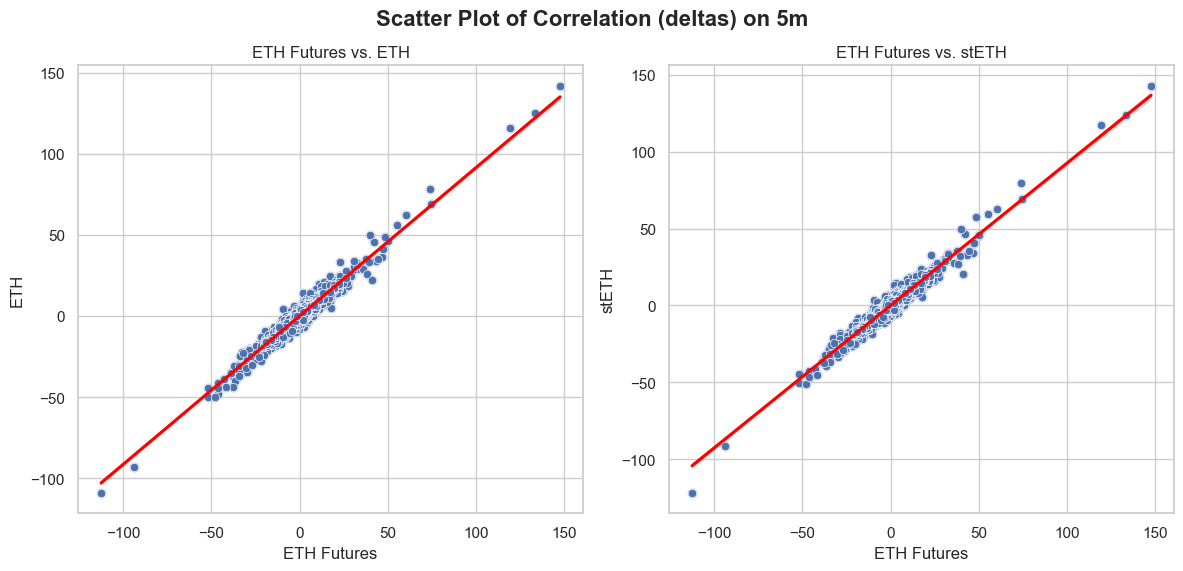

In [1164]:
show_scatters(df_cme_eth_5m, df_cme_steth_5m, '5m')

Data Sourcing:
- `ETH` : Ethereum / USD @ Coinbase from [Trading View](https://www.tradingview.com/) and [Dune](xxx)[*****add queries*****]
- `stETH` : STETHUSDT @ Bybit from [Trading View](https://www.tradingview.com/) and [Dune](xxx)[*****add queries*****]
- `ETH Futures` : CME DataMine from [CME Group](https://datamine.cmegroup.com/)

Data Loads:
- See XXXX (github cme project)